In [1]:
# Characterize germline insertions

In [2]:
from collections import (
    defaultdict,
    namedtuple,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import scipy.stats
import seaborn as sns


TUMOR_PAIRS = {
    'KD-6-tumor': 'KD-6-head',
    'KD-8-tumor': 'KD-8-head',
    'BD-09-tumor': 'BD-9-head',
    'BD-10-tumor': 'BD-10-head'
}
PAIRS = TUMOR_PAIRS.copy()
HEAD_PAIRS = {v:k for k,v in PAIRS.items()}
PAIRS.update({v:k for k,v in PAIRS.items()})


COLUMNS = ['chrom', 'program', 'insertion', 'start', 'end', 'score', 'strand', 'idk', 'attributes']
insertion = namedtuple('Insertion', COLUMNS)

In [3]:
PREFIX = 'Delta Germline'

# PUTATIVE_INSERTIONS = '../../pre-processed-data/raw_insertion_calls/all_putative_germline_insertions.gff3'
PUTATIVE_INSERTIONS = 'putative_delta_germline.gff3'

# COVERAGE_FILE = '../../pre-processed-data/raw_insertion_calls/coverage_over_germline_insertions.tsv'
COVERAGE_FILE = 'delta_coverage_germline.tsv'
ALL_INSERTIONS = 'all_delta_insertions.gff3'
# ALL_INSERTIONS = PUTATIVE_INSERTIONS
SOMATIC_DATA = ['../../pre-processed-data/insertion_calls/0.5.21.filtered_calls_delta_guts.gff', '../../pre-processed-data/insertion_calls/0.5.21.filtered_calls_delta_heads.gff']
INSERTION_SUMMARY = 'Delta All germline TSD insertions.tsv'
FINAL_TABLE = 'Delta Final germline table.tsv'

In [4]:
summary = namedtuple('summary', 'chrom start mate_support split_support nref vaf')


def read_insertions(path):
    all_inserts = defaultdict(list)
    with open(path) as in_fh:
        for line in in_fh:
            fields = line.split()
            chrom = fields[0]
            start = int(fields[3])
            attributes = dict(item.split("=") for item in fields[8].split(";"))
            mate_support = int(attributes['left_mate_count']) + int(attributes['right_mate_count'])
            total_support = int(attributes['total_left_count']) + int(attributes['total_right_count'])
            split_support = total_support - mate_support
            nref = int(attributes['nref'])
            vaf = total_support / (total_support + nref)
            all_inserts[attributes['ID']].append((summary(chrom, start, mate_support, split_support, nref, vaf)))
    return all_inserts

all_inserts = read_insertions(ALL_INSERTIONS)

In [5]:
def find_overlap_support(all_inserts, cluster_id, chrom, start):
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.mate_support, insert.split_support
    return 0, 0

def find_nref(all_inserts, cluster_id, chrom, start):
    # nref = []
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.nref
    return 0

def find_vaf(all_inserts, cluster_id, chrom, start):
    # vaf = []
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.vaf
    return 0

In [6]:
def summarize_overlaps(insertions):
    overlaps = set()
    cluster_ids = set()
    if not insertions:
        raise Exception('nope')
    for index, ins in enumerate(insertions):
        overlaps.add(ins.attributes['ID'].split('_')[0])
        cluster_ids.add(ins.attributes['ID'])
        for overlap in ins.attributes['overlaps'].split(','):
            if overlap:
                cluster_ids.add(overlap)
                overlaps.add(overlap.split('_')[0])
        is_somatic  = (ins.chrom, ins.start, ins.end, ins.insertion) in somatic
    return [index, ins.chrom, ins.start, ins.end, ins.insertion, ins.strand, ins.attributes['genotype'], is_somatic, len(overlaps), cluster_ids]


def get_insertions_by_coordinate(path):
    insertions_by_coordinate = defaultdict(list)
    with open(path) as fh:
        for line in fh:
            fields = line.strip().split('\t')
            fields[8] = dict(item.split("=") for item in fields[8].split(";"))
            ins = insertion(*fields)
            if ins.attributes['valid_TSD'] == 'True':
                insertions_by_coordinate[(ins.chrom, ins.start, ins.end, ins.insertion)].append(ins)
    return insertions_by_coordinate


insertions_by_coordinate = get_insertions_by_coordinate(PUTATIVE_INSERTIONS)


somatic = defaultdict(list)
for dataset in SOMATIC_DATA:
    somatic.update(get_insertions_by_coordinate(dataset))

somatic = {ins: summarize_overlaps(somatic[ins]) for ins in somatic}

In [7]:
len(insertions_by_coordinate)

3521

In [8]:
possible_somatic = {k:v for k, v in insertions_by_coordinate.items() if sum(1 for _ in v if _.attributes['overlaps'].count(',') == 0) == len(v)}

In [9]:
len(possible_somatic)

799

In [10]:
possible_private = defaultdict(list)

for insertions in insertions_by_coordinate.values():
    for record in insertions:
        overlaps = [overlap.split('_')[0] for overlap in record.attributes['overlaps'].split(',')]
        if len(overlaps) == 2 and PAIRS[overlaps[0]] == overlaps[1] and record.attributes['valid_TSD'] == 'True':
            possible_private[(record.chrom, record.start, record.end, record.insertion)].append(record)

In [11]:
early_somatic = {k:v for k,v in possible_private.items() if len(v) == 1}

In [12]:
private = {k:v for k,v in possible_private.items() if len(v) == 2}

In [13]:
def merge_connected_clusters(shared_summary):
    new_summary = []
    n_insertions = len(shared_summary)
    skip = -1
    for i, s in enumerate(shared_summary):
        if not skip == i:
            if i < (n_insertions - 1):
                n_s = shared_summary[i + 1]
                if s[-1] & n_s[-1]:
                    s[-1] = s[-1].union(n_s[-1])
                    skip = i + 1
            s[-2] = len(set(overlap.split('_')[0] for overlap in s[-1]))
            new_summary.append(s)
    return new_summary

<AxesSubplot:xlabel='Number of samples with insertion', ylabel='Number of insertion'>

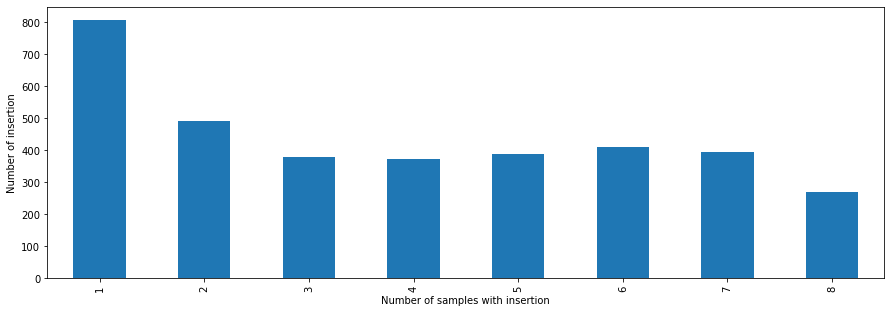

In [14]:
shared_germline = set(insertions_by_coordinate.keys()) - set(possible_somatic.keys()) - set(private.keys())
shared_summary = [summarize_overlaps(insertions_by_coordinate[ins]) for ins in insertions_by_coordinate]

# Make that a recursive call
new_summary = merge_connected_clusters(shared_summary)
new_summary = merge_connected_clusters(list(reversed(new_summary)))
new_summary = merge_connected_clusters(new_summary)
new_summary = list(reversed(merge_connected_clusters(list(reversed(new_summary)))))

shared_df = pd.DataFrame.from_records(shared_summary)
shared_df.columns = ['index', 'chrom', 'start', 'end', 'insertion', 'strand', 'genotype', 'somatic', 'N_samples', 'overlaps']
shared_df['support'] = shared_df.apply(lambda row: [find_overlap_support(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['nref'] = shared_df.apply(lambda row: [find_nref(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['vaf'] = shared_df.apply(lambda row: [find_vaf(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion")

<AxesSubplot:xlabel='Number of samples with insertion, merge aggressively', ylabel='Number of insertion'>

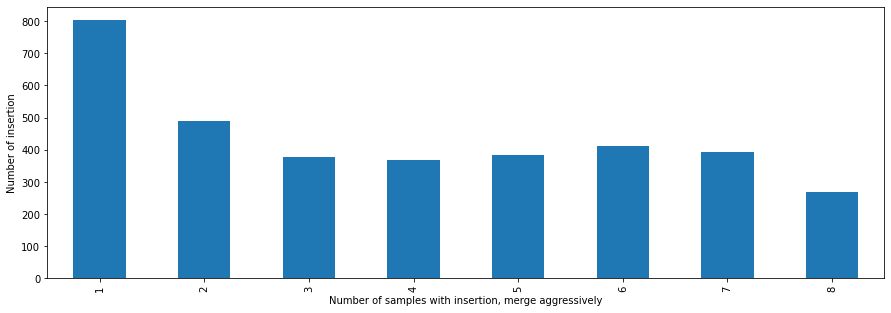

In [15]:
shared_df = pd.DataFrame.from_records(new_summary)
shared_df.columns = ['index', 'chrom', 'start', 'end', 'insertion', 'strand', 'genotype', 'somatic', 'N_samples', 'overlaps']
shared_df['support'] = shared_df.apply(lambda row: [find_overlap_support(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['nref'] = shared_df.apply(lambda row: [find_nref(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['vaf'] = shared_df.apply(lambda row: [find_vaf(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
# shared_df = shared_df[shared_df.somatic == False]
shared_df.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion, merge aggressively")

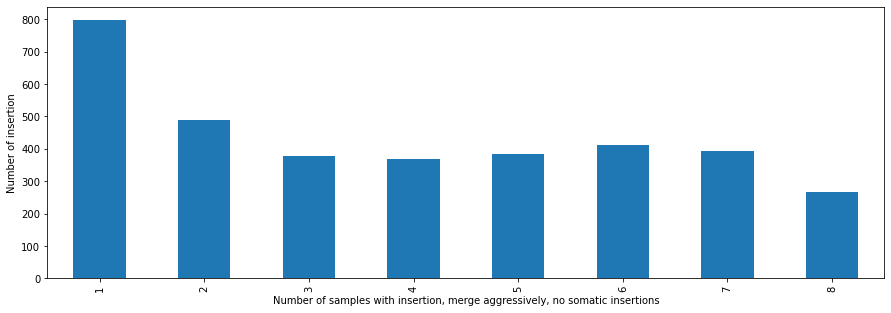

In [16]:
shared_df.somatic = shared_df.apply(lambda row: (row.chrom, row.start, row.end, row.insertion) in somatic, axis=1)
shared_df['private'] = shared_df.apply(lambda row: (row.chrom, row.start, row.end, row.insertion) in possible_private, axis=1)
shared_df.somatic.value_counts()
no_somatic = shared_df[shared_df.somatic == False]
if not no_somatic.empty:
    no_somatic.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion, merge aggressively, no somatic insertions")

In [17]:
shared_df[(shared_df.somatic == False) & (shared_df.N_samples == 1)]

,index,chrom,start,end,insertion,strand,genotype,somatic,N_samples,overlaps,support,nref,vaf,private
0,0,Y,3632209,3632212,Stalker3,+,homozygous,False,1,{KD-6-tumor_414},"[(34, 21)]",[1],[0.9821428571428571],False
2,0,Y,3281368,3281369,Stalker4,+,heterozygous,False,1,{KD-6-tumor_210},"[(8, 2)]",[3],[0.7692307692307693],False
3,0,Y,3019692,3019702,TART-B,+,heterozygous,False,1,{KD-6-tumor_28},"[(7, 19)]",[76],[0.2549019607843137],False
4,0,Y,3017562,3017590,1360,+,heterozygous,False,1,{KD-6-tumor_23},"[(6, 1)]",[8],[0.4666666666666667],False
5,0,Y,2967540,2967583,HeT-A,+,heterozygous,False,1,{KD-6-tumor_316},"[(9, 5)]",[19],[0.42424242424242425],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,0,2L,12286359,12286361,G2,+,heterozygous,False,1,{BD-10-head_20},"[(2, 27)]",[48],[0.37662337662337664],False
3428,0,2L,11317637,11317671,Tabor,+,heterozygous,False,1,{BD-10-head_17},"[(35, 20)]",[12],[0.8208955223880597],False
3450,0,2L,9167381,9167392,mdg1,+,heterozygous,False,1,{BD-10-head_6},"[(13, 38)]",[35],[0.5930232558139535],False
3478,0,2L,5044168,5044170,S-element,+,heterozygous,False,1,{BD-10-head_1},"[(8, 16)]",[26],[0.48],False


In [18]:
shared_df.strand.value_counts()

+    3501
Name: strand, dtype: int64

In [19]:
shared_df[(shared_df.somatic == False) & (shared_df.private == True)].insertion.value_counts()

roo               15
BS                10
opus               9
Tabor              9
F-element          7
hobo               6
297                5
1360               5
mdg1               5
jockey             5
Transpac           4
Juan               4
copia              3
FB                 3
Doc                3
flea               3
Idefix             3
Ivk                3
Rt1b               3
accord2            3
Rt1a               3
Stalker2           2
HeT-A              2
gypsy12            2
pogo               2
S-element          2
3S18               2
springer           2
Cr1a               2
R1A1-element       2
Porto1             1
Stalker            1
gypsy6             1
aurora-element     1
Quasimodo          1
412                1
gypsy5             1
invader2           1
1731               1
HMS-Beagle2        1
gypsy8             1
Doc2-element       1
Max-element        1
baggins            1
HMS-Beagle         1
Doc3-element       1
17.6               1
G-element    

In [20]:
shared_df[(shared_df.somatic == False) & (shared_df.insertion == 'rover')].N_samples.value_counts()

6    3
1    3
8    1
7    1
5    1
3    1
2    1
Name: N_samples, dtype: int64

In [21]:
shared_df[(shared_df.somatic == False) & (shared_df.insertion == 'rover') & (shared_df.N_samples == 68)]

,index,chrom,start,end,insertion,strand,genotype,somatic,N_samples,overlaps,support,nref,vaf,private


In [22]:
shared_df

,index,chrom,start,end,insertion,strand,genotype,somatic,N_samples,overlaps,support,nref,vaf,private
0,0,Y,3632209,3632212,Stalker3,+,homozygous,False,1,{KD-6-tumor_414},"[(34, 21)]",[1],[0.9821428571428571],False
1,0,Y,3618885,3618888,HeT-A,+,heterozygous,False,2,"{KD-6-tumor_409, BD-10-tumor_403}","[(9, 1), (4, 3)]","[6, 3]","[0.625, 0.7]",False
2,0,Y,3281368,3281369,Stalker4,+,heterozygous,False,1,{KD-6-tumor_210},"[(8, 2)]",[3],[0.7692307692307693],False
3,0,Y,3019692,3019702,TART-B,+,heterozygous,False,1,{KD-6-tumor_28},"[(7, 19)]",[76],[0.2549019607843137],False
4,0,Y,3017562,3017590,1360,+,heterozygous,False,1,{KD-6-tumor_23},"[(6, 1)]",[8],[0.4666666666666667],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,6,2L,1340063,1340075,I-element,+,heterozygous,False,7,"{KD-6-head_13, KD-8-tumor_18, BD-10-tumor_33, ...","[(19, 38), (13, 35), (5, 25), (8, 35), (10, 37...","[42, 47, 14, 26, 31, 13, 38]","[0.5757575757575758, 0.5052631578947369, 0.681...",False
3497,5,2L,1241441,1241448,hobo,+,heterozygous,False,6,"{BD-10-head_12, BD-09-tumor_15, BD-10-tumor_23...","[(55, 43), (41, 48), (37, 52), (39, 34), (54, ...","[59, 72, 42, 64, 55, 36]","[0.6242038216560509, 0.5527950310559007, 0.679...",False
3498,6,2L,1074794,1074804,FB,+,heterozygous,False,7,"{KD-6-head_4, BD-09-tumor_8, BD-10-head_5, KD-...","[(26, 37), (32, 42), (26, 53), (18, 30), (14, ...","[38, 39, 34, 30, 35, 43, 19]","[0.6237623762376238, 0.6548672566371682, 0.699...",False
3499,3,2L,629346,629349,Stalker2,+,heterozygous,False,4,"{BD-10-tumor_72, BD-10-head_39, BD-09-tumor_27...","[(5, 23), (23, 48), (9, 38), (9, 28)]","[47, 44, 51, 30]","[0.37333333333333335, 0.6173913043478261, 0.47...",False


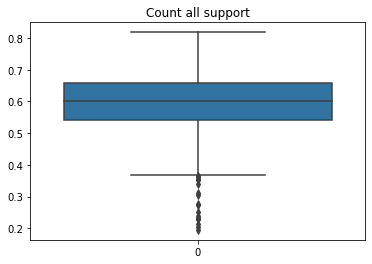

In [23]:
fully_penetrant = shared_df[(shared_df.N_samples == 8) & (shared_df.genotype == 'heterozygous')]
x = fully_penetrant[['chrom', 'start', 'end', 'insertion']]
y = [insertions_by_coordinate[tuple(r)] for r in x.to_records(index=False)]

if not fully_penetrant.empty:
    # All support
    ratio = []
    x_insertions = []
    plt.figure()
    for insertions in y[50:]:
        for ins in insertions:
            if ins.attributes['genotype'] == 'heterozygous' and int(ins.score) > 15:
                if ins.chrom in {'X', 'Y'} and int(ins.score) < 10:
                    x_insertions.append(ins)
                    continue
                nref = int(ins.attributes['nref'])
                score = int(ins.score)
                ratio.append(score /  (score + nref))
    sns.boxplot(data=pd.Series(ratio), orient='v').set_title("Count all support")
    (np.percentile(ratio, q=1), np.percentile(ratio, q=99))

In [24]:
fully_penetrant

,index,chrom,start,end,insertion,strand,genotype,somatic,N_samples,overlaps,support,nref,vaf,private
6,0,Y,2780375,2780404,mdg1,+,heterozygous,False,8,"{BD-10-head_216, KD-6-tumor_200, KD-8-tumor_18...","[(7, 4), (13, 4), (11, 4), (5, 2), (3, 2), (8,...","[2, 11, 11, 1, 1, 7, 3, 1]","[0.8461538461538461, 0.6071428571428571, 0.576...",False
70,0,3R,10201279,10201327,297,+,heterozygous,False,8,"{BD-09-tumor_13, KD-8-tumor_13, KD-8-head_12, ...","[(23, 20), (27, 20), (27, 19), (28, 17), (16, ...","[91, 110, 99, 108, 20, 27, 99, 85]","[0.3208955223880597, 0.29936305732484075, 0.31...",False
104,0,3R,1160294,1160296,gypsy9,+,heterozygous,False,8,"{KD-6-head_98, BD-10-head_103, KD-8-head_99, B...","[(44, 41), (35, 23), (27, 14), (20, 63), (5, 2...","[113, 112, 82, 111, 79, 77, 84, 67, 79, 55]","[0.4292929292929293, 0.3411764705882353, 0.333...",False
123,0,3L,24821886,24821886,Max-element,+,heterozygous,False,8,"{BD-10-tumor_700, KD-8-head_736, BD-10-head_68...","[(20, 4), (13, 6), (21, 2), (9, 3), (8, 2), (1...","[60, 45, 84, 43, 40, 48, 56, 54]","[0.2857142857142857, 0.296875, 0.2149532710280...",False
159,0,3L,2968337,2968353,mdg1,+,heterozygous,False,8,"{KD-6-head_67, BD-9-head_46, BD-09-tumor_77, B...","[(18, 13), (10, 2), (16, 5), (21, 5), (24, 19)...","[67, 8, 47, 22, 103, 57, 27, 39]","[0.3163265306122449, 0.6, 0.3088235294117647, ...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3470,7,2L,6464890,6464894,297,+,heterozygous,False,8,"{BD-10-head_12, KD-6-head_20, BD-10-tumor_38, ...","[(16, 26), (18, 27), (9, 27), (11, 30), (17, 2...","[22, 23, 11, 22, 19, 7, 21, 28]","[0.65625, 0.6617647058823529, 0.76595744680851...",False
3471,7,2L,6293028,6293039,F-element,+,heterozygous,False,8,"{BD-09-tumor_8, BD-10-tumor_28, BD-9-head_5, K...","[(16, 34), (7, 18), (6, 20), (24, 33), (12, 22...","[33, 29, 18, 38, 29, 31, 29, 46]","[0.6024096385542169, 0.46296296296296297, 0.59...",False
3479,7,2L,4933122,4933132,Doc,+,heterozygous,False,8,"{BD-09-tumor_48, KD-8-tumor_41, KD-6-head_44, ...","[(14, 31), (27, 31), (15, 26), (5, 8), (9, 18)...","[21, 30, 18, 10, 13, 21, 24, 25]","[0.6818181818181818, 0.6590909090909091, 0.694...",False
3484,6,2L,3890784,3890797,jockey,+,heterozygous,False,8,"{BD-10-tumor_87, KD-8-head_50, KD-6-head_33, K...","[(15, 20), (22, 13), (17, 29), (18, 22), (5, 9...","[24, 46, 45, 61, 46, 38, 34, 40]","[0.5932203389830508, 0.43209876543209874, 0.50...",False


In [25]:
shared_df.somatic.value_counts()

False    3494
True        7
Name: somatic, dtype: int64

In [26]:
shared_df.N_samples.value_counts()

1    805
2    491
6    411
7    394
5    384
3    379
4    369
8    268
Name: N_samples, dtype: int64

In [27]:
shared_df[(shared_df.somatic == True) & (shared_df.N_samples > 1)]

,index,chrom,start,end,insertion,strand,genotype,somatic,N_samples,overlaps,support,nref,vaf,private
755,0,Y,50331,50347,mdg1,+,heterozygous,True,2,"{KD-8-tumor_25, BD-10-tumor_34}","[(3, 5), (2, 10)]","[14, 29]","[0.36363636363636365, 0.2926829268292683]",False


In [28]:
pretty_summary = shared_df[['chrom', 'start', 'end', 'insertion', 'somatic', 'private', 'N_samples', 'overlaps']]

In [29]:
pretty_summary.to_csv(INSERTION_SUMMARY, sep='\t', index=None)

In [30]:
pretty_summary

,chrom,start,end,insertion,somatic,private,N_samples,overlaps
0,Y,3632209,3632212,Stalker3,False,False,1,{KD-6-tumor_414}
1,Y,3618885,3618888,HeT-A,False,False,2,"{KD-6-tumor_409, BD-10-tumor_403}"
2,Y,3281368,3281369,Stalker4,False,False,1,{KD-6-tumor_210}
3,Y,3019692,3019702,TART-B,False,False,1,{KD-6-tumor_28}
4,Y,3017562,3017590,1360,False,False,1,{KD-6-tumor_23}
...,...,...,...,...,...,...,...,...
3496,2L,1340063,1340075,I-element,False,False,7,"{KD-6-head_13, KD-8-tumor_18, BD-10-tumor_33, ..."
3497,2L,1241441,1241448,hobo,False,False,6,"{BD-10-head_12, BD-09-tumor_15, BD-10-tumor_23..."
3498,2L,1074794,1074804,FB,False,False,7,"{KD-6-head_4, BD-09-tumor_8, BD-10-head_5, KD-..."
3499,2L,629346,629349,Stalker2,False,False,4,"{BD-10-tumor_72, BD-10-head_39, BD-09-tumor_27..."


In [31]:
coverage = pd.read_csv(COVERAGE_FILE, sep='\t')

final_table = pd.concat([shared_df, coverage], axis=1)
final_table['median_coverage'] = final_table.iloc[:, 10:].median(axis=1)


def high_and_low_support(list_of_tuples):
    support_one = sum(list_of_tuples[0])
    if len(list_of_tuples) == 1:
        return False
    support_two = sum(list_of_tuples[1])
    if min(support_one, support_two) < 3 and max(support_one, support_two) > 10:
        return True
    return False


final_table['early_developmental'] = (final_table['somatic'] == False) & (final_table['private'] == True) & (final_table['support'].apply(high_and_low_support))

In [32]:
final_table

,index,chrom,start,end,insertion,strand,genotype,somatic,N_samples,overlaps,...,BD-10-head,BD-9-head,KD-8-head,KD-6-head,BD-10-tumor,BD-09-tumor,KD-8-tumor,KD-6-tumor,median_coverage,early_developmental
0,0,Y,3632209,3632212,Stalker3,+,homozygous,False,1,{KD-6-tumor_414},...,13,4,24,17,9,7,14,31,13.0,False
1,0,Y,3618885,3618888,HeT-A,+,heterozygous,False,2,"{KD-6-tumor_409, BD-10-tumor_403}",...,71,28,49,56,72,85,57,62,57.0,False
2,0,Y,3281368,3281369,Stalker4,+,heterozygous,False,1,{KD-6-tumor_210},...,17,11,56,42,12,28,63,61,28.0,False
3,0,Y,3019692,3019702,TART-B,+,heterozygous,False,1,{KD-6-tumor_28},...,64,43,68,72,79,68,82,85,68.0,False
4,0,Y,3017562,3017590,1360,+,heterozygous,False,1,{KD-6-tumor_23},...,64,43,68,72,79,68,82,85,68.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,6,2L,1340063,1340075,I-element,+,heterozygous,False,7,"{KD-6-head_13, KD-8-tumor_18, BD-10-tumor_33, ...",...,18,8,21,22,13,11,21,14,14.0,False
3497,5,2L,1241441,1241448,hobo,+,heterozygous,False,6,"{BD-10-head_12, BD-09-tumor_15, BD-10-tumor_23...",...,20,18,26,25,25,21,8,26,21.0,False
3498,6,2L,1074794,1074804,FB,+,heterozygous,False,7,"{KD-6-head_4, BD-09-tumor_8, BD-10-head_5, KD-...",...,20,18,26,25,25,21,8,26,21.0,False
3499,3,2L,629346,629349,Stalker2,+,heterozygous,False,4,"{BD-10-tumor_72, BD-10-head_39, BD-09-tumor_27...",...,20,18,26,25,25,21,8,26,21.0,False


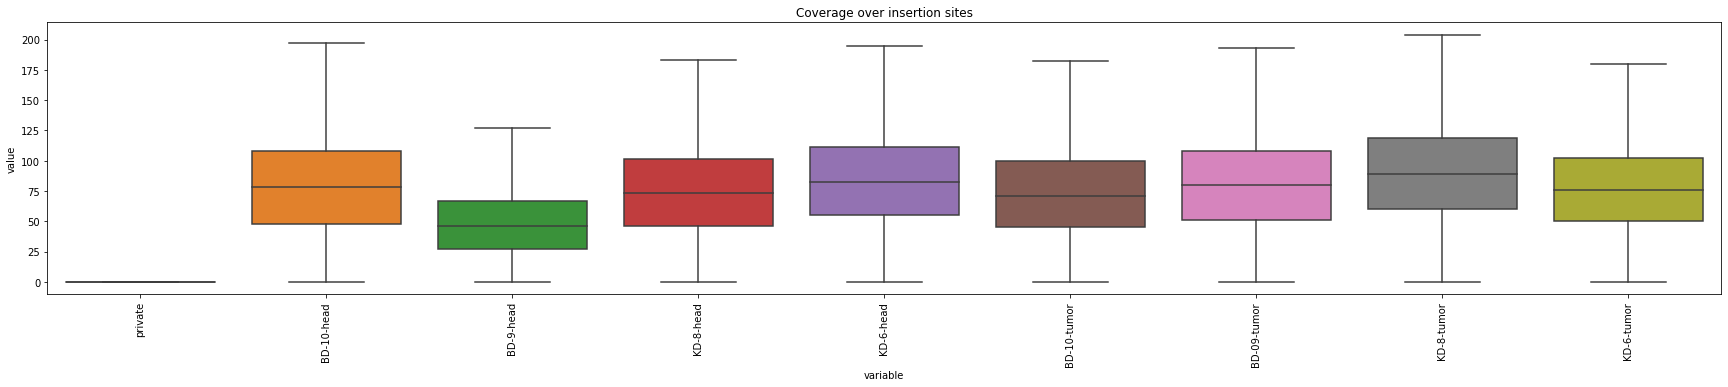

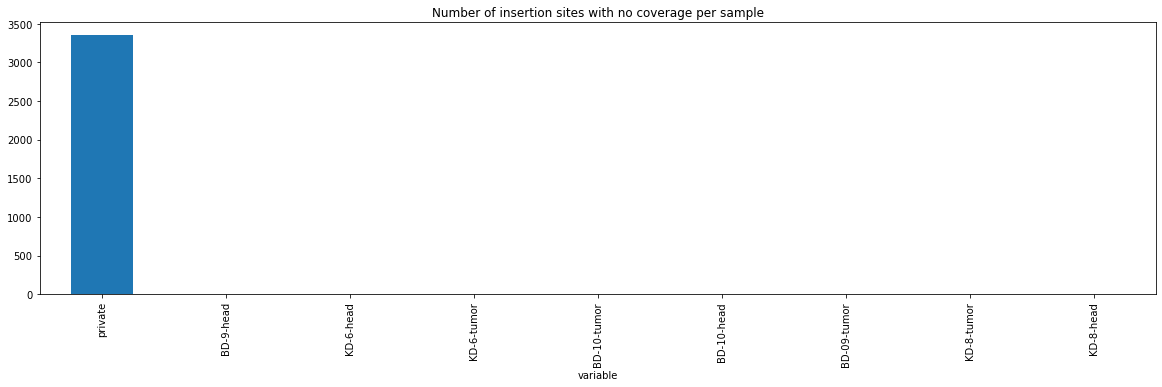

In [33]:
def plot_coverage_data(coverage_data):
    # Coverage over insertion sites
    fig, ax = plt.subplots(figsize=(30, 5))
    sns.boxplot(x='variable', y='value', showfliers = False, data=coverage_data, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title('Coverage over insertion sites')
    
    # Insertion sites without coverage
    fig, ax = plt.subplots(figsize=(30, 5))
    germline_sites_without_coverage = coverage_data['value'].eq(0).astype(int).groupby(coverage_data['variable']).sum().sort_values(ascending=False)
    germline_sites_without_coverage.plot(kind='bar', x='sample', y='count', figsize=(20, 5), title='Number of insertion sites with no coverage per sample', ax=ax)

coverage_data = final_table.iloc[:, 13:-2].melt()
plot_coverage_data(coverage_data)

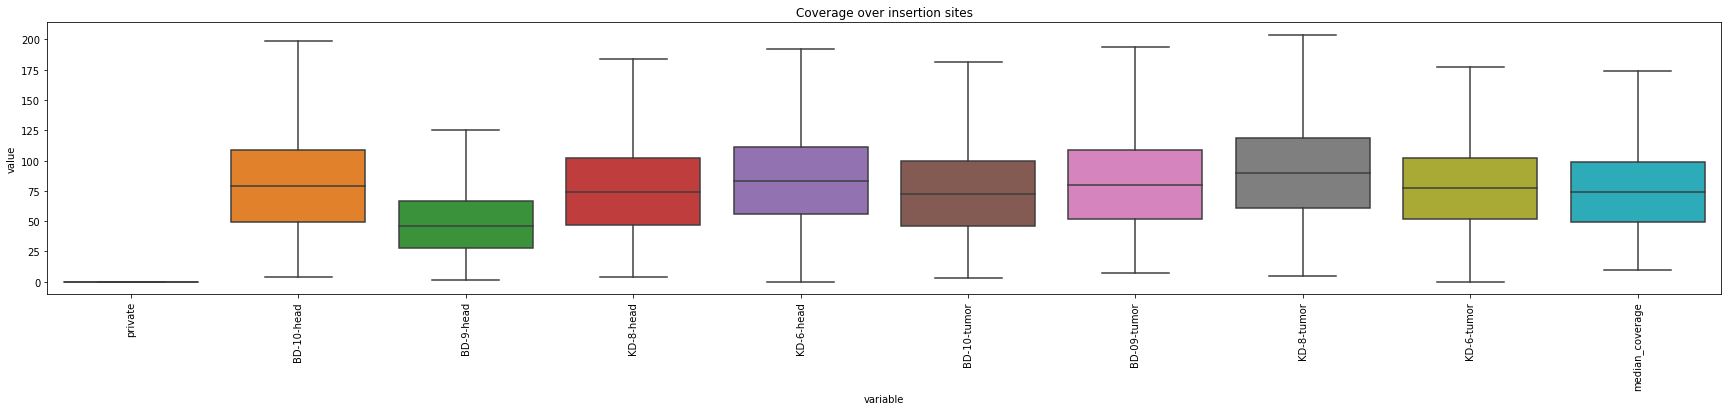

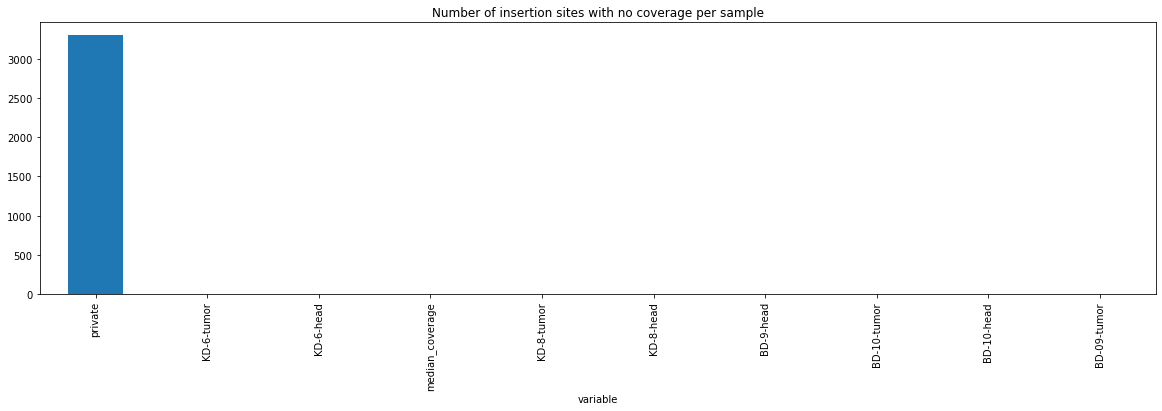

In [34]:
coverage_data = final_table[final_table.median_coverage >= 10].iloc[:, 13:-1].melt()
plot_coverage_data(coverage_data)

In [35]:
final_table

,index,chrom,start,end,insertion,strand,genotype,somatic,N_samples,overlaps,...,BD-10-head,BD-9-head,KD-8-head,KD-6-head,BD-10-tumor,BD-09-tumor,KD-8-tumor,KD-6-tumor,median_coverage,early_developmental
0,0,Y,3632209,3632212,Stalker3,+,homozygous,False,1,{KD-6-tumor_414},...,13,4,24,17,9,7,14,31,13.0,False
1,0,Y,3618885,3618888,HeT-A,+,heterozygous,False,2,"{KD-6-tumor_409, BD-10-tumor_403}",...,71,28,49,56,72,85,57,62,57.0,False
2,0,Y,3281368,3281369,Stalker4,+,heterozygous,False,1,{KD-6-tumor_210},...,17,11,56,42,12,28,63,61,28.0,False
3,0,Y,3019692,3019702,TART-B,+,heterozygous,False,1,{KD-6-tumor_28},...,64,43,68,72,79,68,82,85,68.0,False
4,0,Y,3017562,3017590,1360,+,heterozygous,False,1,{KD-6-tumor_23},...,64,43,68,72,79,68,82,85,68.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,6,2L,1340063,1340075,I-element,+,heterozygous,False,7,"{KD-6-head_13, KD-8-tumor_18, BD-10-tumor_33, ...",...,18,8,21,22,13,11,21,14,14.0,False
3497,5,2L,1241441,1241448,hobo,+,heterozygous,False,6,"{BD-10-head_12, BD-09-tumor_15, BD-10-tumor_23...",...,20,18,26,25,25,21,8,26,21.0,False
3498,6,2L,1074794,1074804,FB,+,heterozygous,False,7,"{KD-6-head_4, BD-09-tumor_8, BD-10-head_5, KD-...",...,20,18,26,25,25,21,8,26,21.0,False
3499,3,2L,629346,629349,Stalker2,+,heterozygous,False,4,"{BD-10-tumor_72, BD-10-head_39, BD-09-tumor_27...",...,20,18,26,25,25,21,8,26,21.0,False


In [36]:

final_table[final_table['early_developmental']]

,index,chrom,start,end,insertion,strand,genotype,somatic,N_samples,overlaps,...,BD-10-head,BD-9-head,KD-8-head,KD-6-head,BD-10-tumor,BD-09-tumor,KD-8-tumor,KD-6-tumor,median_coverage,early_developmental
1319,0,2R,1022413,1022425,accord2,+,heterozygous,False,2,"{KD-6-head_41, KD-6-tumor_35}",...,104,63,93,74,101,120,101,89,93.0,True
1699,0,2R,3023774,3023814,X-element,+,heterozygous,False,2,"{KD-8-tumor_27, KD-8-head_21}",...,15,16,21,23,18,35,32,28,21.0,True


Text(0.5, 1.0, 'Germline private TE insertions')

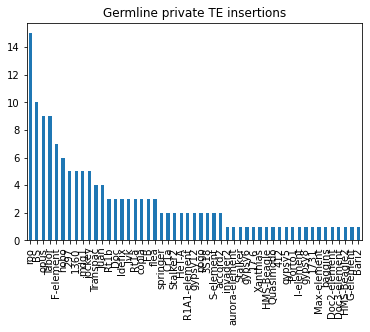

In [37]:
final_table[(~final_table['early_developmental']) & (final_table['private'])].insertion.value_counts().plot(kind='bar').set_title('Germline private TE insertions')

Text(0.5, 1.0, 'Germline private TE insertions')

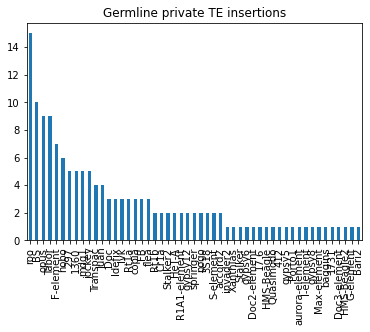

In [38]:
final_table[(final_table['median_coverage'] >=10) & (~final_table['early_developmental']) & (final_table['private'])].insertion.value_counts().plot(kind='bar').set_title('Germline private TE insertions')

In [39]:
final_table[(~final_table['early_developmental']) & (final_table['private']) & (final_table['insertion'] == 'copia')]

,index,chrom,start,end,insertion,strand,genotype,somatic,N_samples,overlaps,...,BD-10-head,BD-9-head,KD-8-head,KD-6-head,BD-10-tumor,BD-09-tumor,KD-8-tumor,KD-6-tumor,median_coverage,early_developmental
1337,1,2R,39294,39300,copia,+,heterozygous,False,2,"{KD-6-tumor_26, KD-6-head_25}",...,191,91,189,221,132,168,187,209,187.0,False
1357,1,2L,22085546,22085550,copia,+,heterozygous,False,2,"{KD-6-head_32, KD-6-tumor_53}",...,71,63,83,83,79,96,88,86,83.0,False
2105,1,2L,9042516,9042520,copia,+,heterozygous,False,2,"{BD-9-head_0, BD-09-tumor_1}",...,105,55,110,72,94,74,46,85,74.0,False


In [40]:
final_table[final_table['median_coverage'] < 10]

,index,chrom,start,end,insertion,strand,genotype,somatic,N_samples,overlaps,...,BD-10-head,BD-9-head,KD-8-head,KD-6-head,BD-10-tumor,BD-09-tumor,KD-8-tumor,KD-6-tumor,median_coverage,early_developmental
464,0,2R,2169082,2169095,BS,+,heterozygous,False,2,"{KD-8-tumor_188, BD-9-head_105}",...,19,3,4,16,4,8,14,5,5.0,False
470,0,2R,1630933,1630954,Doc,+,heterozygous,False,1,{KD-8-tumor_765},...,14,9,6,12,5,8,12,10,9.0,False
540,0,X,3104945,3104955,opus,+,homozygous,False,1,{BD-09-tumor_12},...,4,1,4,6,9,5,4,5,4.0,False
552,0,3R,25858692,25858699,hobo,+,heterozygous,False,1,{BD-09-tumor_33},...,10,4,10,3,4,6,6,4,4.0,False
631,0,3L,23360969,23360986,gypsy2,+,heterozygous,False,1,{BD-09-tumor_383},...,2,0,2,3,2,2,6,5,2.0,False
634,0,3L,23055410,23055425,mdg1,+,heterozygous,False,1,{BD-09-tumor_40},...,9,5,7,6,4,14,12,9,7.0,False
773,0,X,21585579,21585585,mariner2,+,heterozygous,False,5,"{KD-8-tumor_111, KD-6-head_110, BD-9-head_89, ...",...,9,2,4,17,4,7,15,12,7.0,False
774,1,X,20978902,20978917,Tabor,+,heterozygous,False,2,"{KD-6-tumor_129, BD-10-tumor_103}",...,8,2,4,17,4,7,15,12,7.0,False
811,1,4,332515,332515,INE-1,+,homozygous,False,4,"{BD-10-head_141, BD-10-tumor_178, BD-09-tumor_...",...,5,0,4,9,8,13,14,16,8.0,False
821,0,3R,18333103,18333132,hopper,+,heterozygous,False,5,"{KD-6-head_23, BD-10-tumor_48, BD-09-tumor_33,...",...,5,0,1,3,1,1,8,8,1.0,False


In [41]:
final_table.to_csv(FINAL_TABLE, sep='\t', index=None)

In [42]:
x = []
def expand_row(row):
    for index, (sample, vaf) in enumerate(zip(row['overlaps'], row['vaf'])):
        sample = sample.rsplit('_', 1)[0]
        coverage = row[sample]
        if sum(row['support'][index]) > 0:
            x.append((row['chrom'], row['start'], row['end'], row['insertion'], sample, coverage, vaf, row['N_samples'], row['genotype']))

final_table.apply(lambda row: expand_row(row), axis=1)
coverage_per_insertion = pd.DataFrame.from_records(x)
coverage_per_insertion.columns = ['chrom', 'start', 'end', 'insertion', 'sample', 'coverage', 'vaf', 'N_samples', 'genotype']

/Users/mvandenb/miniconda3/envs/somatic-transposition-fly-intestine/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


LinregressResult(slope=0.0006414847880345211, intercept=0.6430753529346189, rvalue=0.09861711348554605, pvalue=1.6867266666525362e-06, stderr=0.0001336435199538344)

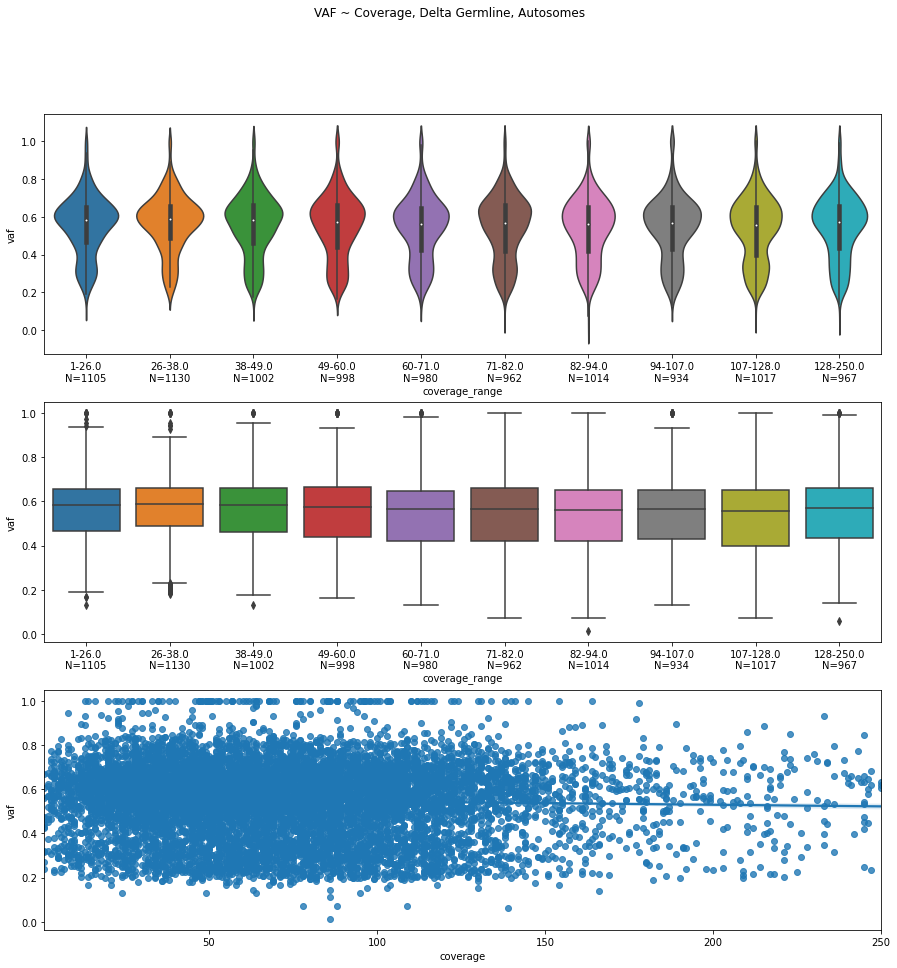

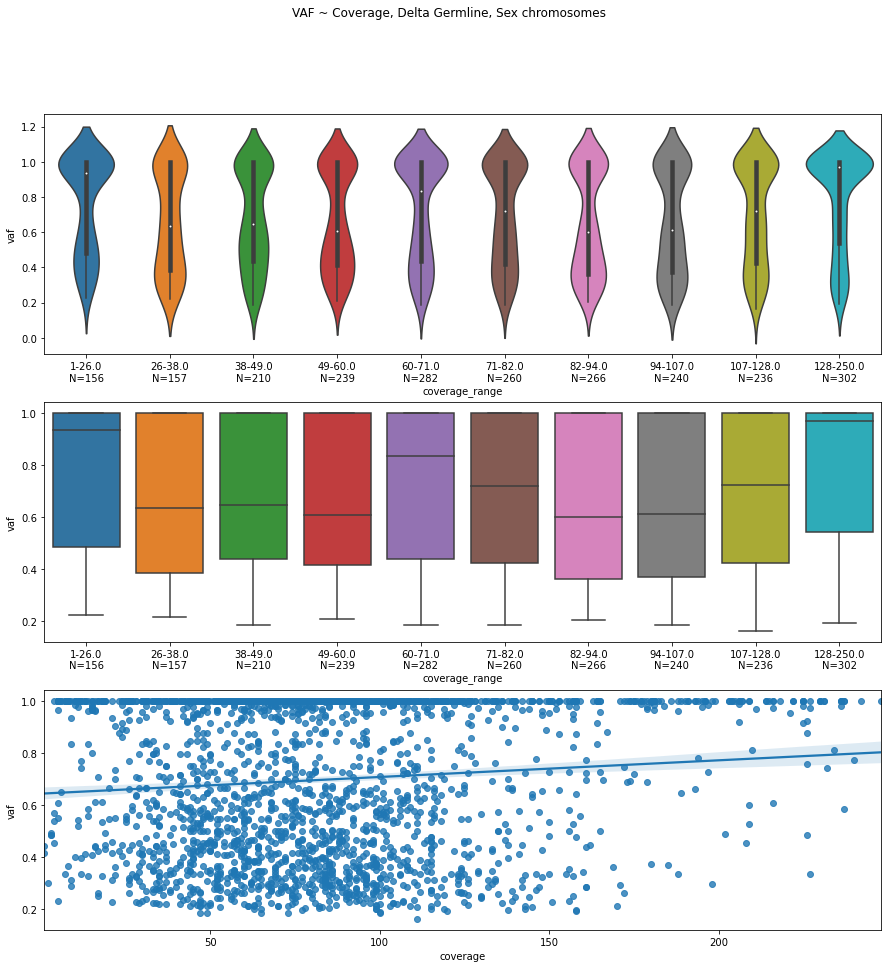

In [43]:
reasonable_coverage = coverage_per_insertion[(coverage_per_insertion.coverage >= 1) & (coverage_per_insertion.coverage <= 250)]
reasonable_coverage[reasonable_coverage.N_samples > 10]
reasonable_coverage['coverage_range'] = pd.qcut(reasonable_coverage.coverage, q=10)
autosomes = reasonable_coverage[~reasonable_coverage['chrom'].isin({'X', 'Y'})]
autosomes = autosomes[autosomes.genotype == 'heterozygous']
sex_chromosomes = reasonable_coverage[reasonable_coverage['chrom'].isin({'X', 'Y'})]

def plot_coverage_vaf_relationship(df, title='Coverage-VAF relationship'):
    fig, axes = plt.subplots(nrows=3, figsize=(15, 15))
    fig.suptitle(title)
    sns.violinplot(x='coverage_range', y='vaf', data=df, ax=axes[0])
    sns.boxplot(x='coverage_range', y='vaf', data=df, ax=axes[1])
    xlabels = df.coverage_range.value_counts().sort_index().reset_index().apply(lambda row: f"{round(row['index'].left)}-{row['index'].right}\nN={row['coverage_range']}", axis=1).to_list()
    axes[0].set_xticklabels(xlabels)
    axes[1].set_xticklabels(xlabels)
    sns.regplot(x='coverage', y='vaf', data=df, ax=axes[2])
    fig.savefig(f"{title}.pdf")
    return scipy.stats.linregress(df['coverage'], df['vaf'])


plot_coverage_vaf_relationship(autosomes, title=f'VAF ~ Coverage, {PREFIX}, Autosomes')
plot_coverage_vaf_relationship(sex_chromosomes, title=f'VAF ~ Coverage, {PREFIX}, Sex chromosomes')
